In [16]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import polars as pl
import numpy as np
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor
from model_script.script_XGBoost_model_polars import DataCleaner, FeatureCreator, AnomalyFilter, WeightedPOICountsTransformer, data_loader, build_xgboost_model,save_model,plot_train_test_predictions

In [17]:
YEARS =["2022"]# ["2019","2020", "2021", "2022", "2023","2024"]
PREPROCESSED_FILE = "data_processed/data_dvf_preprocessed_test_explicabilite_IDF.csv"
BATCH_SIZE = 100_000
dep = []

print("Starting preprocessing by year...")
# Charger la grille pour le pipeline
df_grid = pl.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')

# Définir le pipeline de preprocessing
pipeline_preprocess = Pipeline(steps=[
    ("cleaner", DataCleaner(nombre_lots_max=5, cutoff_valeur_fonciere_min=0.75e5, min_surface=15)),
    ("feature_creator", FeatureCreator(cutoff_prix_m2_min=3e3,cutoff_prix_m2_max=18e3)),
    ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
    ("anomaly_filter", AnomalyFilter(contamination=0.1, target_elimination=True, prix_m2= True)),
    # ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
])

pipeline_preprocess.set_params(weighted_poi__df_grid=df_grid)

with open(PREPROCESSED_FILE, "w") as f:
    pass

# === 1. Charger et prétraiter chaque année séparément ===
for year in YEARS:
    print(f"Processing year {year}...")

    # Charger les données de l'année en cours
    df_year = data_loader('data_dvf', annees=[year],departements=dep)
    print(f"Data loaded for {year}: {df_year.shape[0]} rows")

    # Appliquer le préprocessing
    df_processed = pipeline_preprocess.fit_transform(df_year)
    df_processed.drop_nulls()
    print(f"Data processed for {year}: {df_processed.shape[0]} rows")

    # Sauvegarder les données prétraitées en ajoutant au CSV
    with open(PREPROCESSED_FILE, mode="a") as f:
        df_processed.write_csv(f,include_header=True)

print("All years processed and saved!")

Starting preprocessing by year...
Processing year 2019...
Data loaded for 2019: 1967866 rows
Shape before filtering: (1967866, 15)
Shape after filtering: (1082429, 15)
Data processed for 2019: 124831 rows
Processing year 2020...
Data loaded for 2020: 3522100 rows
Shape before filtering: (3522100, 15)
Shape after filtering: (1963783, 15)
Data processed for 2020: 218777 rows
Processing year 2021...
Data loaded for 2021: 4672561 rows
Shape before filtering: (4672561, 15)
Shape after filtering: (2753043, 15)
Data processed for 2021: 269337 rows
Processing year 2022...
Data loaded for 2022: 4667090 rows
Shape before filtering: (4667090, 15)
Shape after filtering: (2769447, 15)
Data processed for 2022: 283306 rows
Processing year 2023...
Data loaded for 2023: 3799407 rows
Shape before filtering: (3799407, 15)
Shape after filtering: (2177381, 15)
Data processed for 2023: 215200 rows
Processing year 2024...
Data loaded for 2024: 1566643 rows
Shape before filtering: (1566643, 15)
Shape after fi

In [18]:
df_lazy = pl.scan_csv(
            PREPROCESSED_FILE,
            has_header = True,
            schema_overrides={
                'surface_reelle_bati': pl.Float32,
                'type_local': pl.Utf8,  # Optimisation mémoire
                'year': pl.Int32,  # Réduction mémoire
                'sin_month': pl.Float32,
                'cos_month': pl.Float32,
                'nombre_lots': pl.Float32,
                'total_surface_carrez': pl.Float32,
                'lot1_surface_carrez': pl.Float32,
                'lot2_surface_carrez': pl.Float32,
                'lot3_surface_carrez': pl.Float32,
                'lot4_surface_carrez': pl.Float32,
                'lot5_surface_carrez': pl.Float32,
                'nombre_pieces_principales': pl.Float32,
                'surface_terrain': pl.Float32,
                'longitude': pl.Float32,
                'latitude': pl.Float32,
                'prix_m2': pl.Float64,
                'densite_weighted': pl.Float32,
                'transport_pois_weighted': pl.Float32,
                'education_pois_weighted': pl.Float32,
                'health_pois_weighted': pl.Float32,
                'food_pois_weighted': pl.Float32,
                'shopping_pois_weighted': pl.Float32,
                'park_pois_weighted': pl.Float32,
                'entertainment_pois_weighted': pl.Float32,
                'cultural_pois_weighted': pl.Float32
            },
            ignore_errors = True
        ).drop_nulls()


# === 3. Séparation Train / Test (Lazy) ===
df = df_lazy.collect().sample(fraction=1.0,shuffle=True) # Convertit en DataFrame
df = df.with_columns(pl.lit(np.random.rand(len(df))).alias("split"))  # Ajoute une colonne random
df_lazy = df.lazy()  # Reconvertit en LazyFrame# Ajoute une colonne random
df_train = df_lazy.filter(pl.col("split") < 0.8).drop("split")  # 80% pour l'entraînement
df_test = df_lazy.filter(pl.col("split") >= 0.8).drop("split")  # 20% pour le test

df_train_features = df_train.drop("prix_m2")
df_train_target = df_train.select("prix_m2")
print(df_train_features.collect().shape)

df_test_features = df_test.drop("prix_m2")
df_test_target = df_test.select("prix_m2")
print(df_test_features.collect().shape)


(955362, 25)
(238615, 25)


In [19]:
# === 1. Préparation des données ===
# Caractéristiques pour le modèle physique
physical_features = ['surface_reelle_bati', 'type_local', 'nombre_pieces_principales','nombre_lots','total_surface_carrez',
                     'lot1_surface_carrez', 'lot2_surface_carrez','lot3_surface_carrez', 'lot4_surface_carrez',
                     'lot5_surface_carrez','surface_terrain']

# Caractéristiques pour le modèle localisation
contextual_features = ['year', 'sin_month', 'cos_month','longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted']

# === 2. Pipelines d'encodage ===
categorical_columns_physical = ['type_local']
numerical_columns_physical = ['surface_reelle_bati', 'nombre_pieces_principales','nombre_lots','total_surface_carrez',
                     'lot1_surface_carrez', 'lot2_surface_carrez','lot3_surface_carrez', 'lot4_surface_carrez',
                     'lot5_surface_carrez','surface_terrain']
numerical_columns_contextual = ['year', 'sin_month', 'cos_month','longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted']

# Catégories uniques pour l'encodage OneHot
unique_categories = [df_lazy.select(col).drop_nulls().unique().collect().to_series().to_list()
                      for col in categorical_columns_physical]

# Pipeline pour les caractéristiques physiques
physical_pipeline = ColumnTransformer([
    ('onehot', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', categories=unique_categories))
    ]), categorical_columns_physical),
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', RobustScaler())
    ]), numerical_columns_physical)
])

# Pipeline pour les caractéristiques de localisation
contextual_pipeline = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', RobustScaler())
    ]), numerical_columns_contextual)
])

# === 3. Paramètres des modèles ===
# params_physical = {
#     "objective": "reg:squarederror",
#     "learning_rate": 0.5,
#     "max_depth": 8,
#     "n_estimators" : 200,
#     "n_jobs": 2,
#     "subsample": 0.8,
#     "gamma": 0.1,
#     "min_child_weight": 10,
#     "lambda": 1,
#     "alpha": 0.5
# }
params_physical = {
    "alpha": 0.5,         # Force globale de régularisation (plus alpha est grand, plus le modèle est contraint)
    "l1_ratio": 0.5,      # Proportion entre L1 et L2 (0.5 correspond à une combinaison équilibrée ; 1 = Lasso, 0 = Ridge)
    "max_iter": 1000,     # Nombre maximal d’itérations pour la convergence
    "tol": 1e-4,          # Tolérance pour le critère d’arrêt
    "fit_intercept": True # Inclure un intercept dans le modèle
}
params_contextual = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 8,
    "n_estimators" : 200,
    "n_jobs": 2,
    "subsample": 0.9,
    "gamma": 0.2,
    "min_child_weight": 5,
    "lambda": 1,
    "alpha": 0.3
}


In [20]:
# # === Custom Estimator to combine predictions ===
# class CombinedModel(BaseEstimator, RegressorMixin):
#     def __init__(self, physical_model, contextual_model):
#         self.physical_model = physical_model
#         self.contextual_model = contextual_model

#     def fit(self, X, y):
#         X_physical = X[physical_features]
#         X_contextual = X[contextual_features]

#         self.physical_model.fit(X_physical, y)
#         self.contextual_model.fit(X_contextual, y)
#         return self

#     def predict(self, X):
#         X_physical = X[physical_features]
#         X_contextual = X[contextual_features]

#         pred_physical = self.physical_model.predict(X_physical)
#         pred_contextual = self.contextual_model.predict(X_contextual)

#         return pred_physical + pred_contextual


In [21]:
# # Pipeline for physical features
# physical_pipeline = ColumnTransformer([
#     ('onehot', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore', categories=unique_categories))
#     ]), categorical_columns_physical),
#     ('numeric', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('scaler', RobustScaler())
#     ]), numerical_columns_physical)
# ])

# # Pipeline for contextual features
# contextual_pipeline = ColumnTransformer([
#     ('numeric', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('scaler', RobustScaler())
#     ]), numerical_columns_contextual)
# ])

# # Physical model pipeline
# physical_model_pipeline = Pipeline([
#     ('preprocessing', physical_pipeline),
#     ('model', xgb.XGBRegressor(**params_physical))
# ])

# # Contextual model pipeline
# contextual_model_pipeline = Pipeline([
#     ('preprocessing', contextual_pipeline),
#     ('model', xgb.XGBRegressor(**params_contextual))
# ])

# # Combined model pipeline
# combined_pipeline = Pipeline([
#     ('combined_model', CombinedModel(
#         physical_model=physical_model_pipeline,
#         contextual_model=contextual_model_pipeline
#     ))
# ])

In [22]:
class CombinedXGBModel(BaseEstimator, RegressorMixin):
    def __init__(self, physical_params, contextual_params, physical_weight=0.5, save=False, stacking=False):
        self.physical_params = physical_params
        self.contextual_params = contextual_params
        self.physical_weight = physical_weight
        self.contextual_weight = 1 - physical_weight
        self.save = save
        self.stacking = stacking
        self._build_models()

    def _build_models(self):
        self.physical_model = ElasticNet(**self.physical_params)
        self.contextual_model = xgb.XGBRegressor(**self.contextual_params)

        if self.stacking:
            self.stacking_model = StackingRegressor(
                estimators=[('physical', self.physical_model), ('contextual', self.contextual_model)],
                final_estimator=ElasticNet(fit_intercept=False),
                passthrough=True
            )

    def fit(self, X, y):
        if isinstance(X, CustomTupleWrapper):
            X_physical, X_contextual = X.X_physical, X.X_contextual
        elif isinstance(X, (list, np.ndarray)):
            sample = X[0]
            if isinstance(sample, (tuple, list)) and len(sample) == 2:
                X_physical, X_contextual = map(np.array, zip(*X))
            else:
                raise ValueError("X n'est pas au format attendu (liste de tuples à 2 éléments).")
        else:
            X_physical, X_contextual = X

        if self.stacking:
            X_combined = np.hstack((X_physical, X_contextual))
            self.stacking_model.fit(X_combined, y)
        else:
            self.physical_model.fit(X_physical, y)
            self.contextual_model.fit(X_contextual, y)

        return self

    def predict(self, X):
        if isinstance(X, CustomTupleWrapper):
            X_physical, X_contextual = X.X_physical, X.X_contextual
        elif isinstance(X, (list, np.ndarray)):
            sample = X[0]
            if isinstance(sample, (tuple, list)) and len(sample) == 2:
                X_physical, X_contextual = map(np.array, zip(*X))
            else:
                raise ValueError("X n'est pas au format attendu (liste de tuples à 2 éléments).")
        else:
            X_physical, X_contextual = X

        if self.stacking:
            X_combined = np.hstack((X_physical, X_contextual))
            return self.stacking_model.predict(X_combined)
        else:
            pred_physical = self.physical_model.predict(X_physical)
            pred_contextual = self.contextual_model.predict(X_contextual)
            combined_preds = (self.physical_weight * pred_physical + self.contextual_weight * pred_contextual)
            return combined_preds

    def save_models(self, directory='saved_models'):
        if not os.path.exists(directory):
            os.makedirs(directory)
        if self.stacking:
            joblib.dump(self.stacking_model, os.path.join(directory, 'stacking_model.pkl'))
        else:
            joblib.dump(self.physical_model, os.path.join(directory, 'physical_model.pkl'))
            joblib.dump(self.contextual_model, os.path.join(directory, 'contextual_model.pkl'))

    def load_models(self, directory='saved_models'):
        if self.stacking:
            self.stacking_model = joblib.load(os.path.join(directory, 'stacking_model.pkl'))
        else:
            self.physical_model = joblib.load(os.path.join(directory, 'physical_model.pkl'))
            self.contextual_model = joblib.load(os.path.join(directory, 'contextual_model.pkl'))

    def get_params(self, deep=True):
        params = {
            'physical_params': self.physical_params,
            'contextual_params': self.contextual_params,
            'physical_weight': self.physical_weight,
            'save': self.save,
            'stacking': self.stacking
        }
        if deep:
            for key, val in self.physical_params.items():
                params[f'physical_params__{key}'] = val
            for key, val in self.contextual_params.items():
                params[f'contextual_params__{key}'] = val
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if key.startswith("physical_params__"):
                subkey = key.split("__", 1)[1]
                self.physical_params[subkey] = value
            elif key.startswith("contextual_params__"):
                subkey = key.split("__", 1)[1]
                self.contextual_params[subkey] = value
            else:
                setattr(self, key, value)
        self._build_models()
        return self

class CustomGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, **kwargs):
        super().__init__(estimator, param_grid, **kwargs)

    def fit(self, X, y=None, **fit_params):
        # Si X est un tuple de matrices, on ajuste la validation de GridSearchCV
        if isinstance(X, tuple):
            X = CustomTupleWrapper(X)  # Enveloppe le tuple pour éviter l'erreur de validation
        else:
            X = self._split_features(X)

        return super().fit(X, y, **fit_params)

    def predict(self, X):
        if isinstance(X, tuple):
            X = CustomTupleWrapper(X)
        else:
            X = self._split_features(X)

        return super().predict(X)

    def _split_features(self, X):
        X_physical = X[:, :X.shape[1] // 2]
        X_contextual = X[:, X.shape[1] // 2:]
        return CustomTupleWrapper((X_physical, X_contextual))

class CustomTupleWrapper:
    """Encapsule un tuple (X_physical, X_contextual) et se comporte comme une séquence d’échantillons.
       Pour chaque index i, __getitem__(i) retourne (X_physical[i], X_contextual[i])."""
    def __init__(self, X_tuple):
        self.X_physical, self.X_contextual = X_tuple

    def __getitem__(self, index):
        # Si index est un entier, on retourne un tuple pour cet échantillon
        # Si c'est une tranche (slice), on retourne une nouvelle instance du wrapper avec les tranches correspondantes
        if isinstance(index, slice):
            return CustomTupleWrapper((self.X_physical[index], self.X_contextual[index]))
        else:
            return (self.X_physical[index], self.X_contextual[index])

    def __len__(self):
        return len(self.X_physical)

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]


In [23]:
def train_combined_model(df_features, df_target, save=False, stacking = False):
    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())
    X_combined = (X_physical, X_contextual)
    y_train = df_target.collect().to_numpy().ravel()

    # Entraînement du modèle combiné
    combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual, stacking=stacking)
    combined_model.fit(X_combined, y_train)

    if save:
        combined_model.save_models()  # Sauvegarde des modèles

    return combined_model



# === 6. Prédiction combinée ===
def combined_prediction(model, df_features):
    X_physical = physical_pipeline.transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.transform(df_features.select(contextual_features).collect())
    X_combined = (X_physical, X_contextual)  # Créer le tuple pour les prédictions
    return model.predict(X_combined)


def grid_search_combined_model(df_features, df_target, save=False):
    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())

    # Combiner les deux matrices en un seul tuple
    X_combined = (X_physical, X_contextual)

    y_train = df_target.collect().to_numpy().ravel()

    # Définir le modèle combiné avec les hyperparamètres
    combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual)

    # Paramètres à tester dans GridSearch
    param_grid = {
    'physical_weight': [0.1, 0.3, 0.5, 0.7, 0.9],
    # 'physical_params__n_estimators': [100, 200],
    # 'physical_params__max_depth': [6, 8, 10],
    # 'physical_params__learning_rate': [0.1, 0.3, 0.5],
    # 'contextual_params__n_estimators': [100, 200],
    # 'contextual_params__max_depth': [4, 6, 8],
    # 'contextual_params__learning_rate': [0.1, 0.3, 0.5]
    }


    # Utiliser la version personnalisée de GridSearchCV
    grid_search = CustomGridSearchCV(estimator=combined_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

    # Ajustement du modèle
    grid_search.fit(X_combined, y_train)

    # Meilleur modèle et meilleurs paramètres
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Sauvegarder le meilleur modèle
    if save:
        best_model.save_models()  # Sauvegarde des modèles

    return best_model, best_params


In [24]:
combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual)
combined_model.get_params

<bound method CombinedXGBModel.get_params of CombinedXGBModel(contextual_params={'alpha': 0.3, 'gamma': 0.2, 'lambda': 1,
                                    'learning_rate': 0.1, 'max_depth': 8,
                                    'min_child_weight': 5, 'n_estimators': 200,
                                    'n_jobs': 2,
                                    'objective': 'reg:squarederror',
                                    'subsample': 0.9},
                 physical_params={'alpha': 0.5, 'fit_intercept': True,
                                  'l1_ratio': 0.5, 'max_iter': 1000,
                                  'tol': 0.0001})>

In [25]:
# best_model, best_params = grid_search_combined_model(df_train_features, df_train_target)
# y_pred_test = combined_prediction(best_model, df_test_features)

In [26]:
# print(best_params)
# y_test = df_test_target.collect().to_numpy().ravel()
# dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# # Tri des données
# bins = np.arange(min(y_test), max(y_test) + dx, dx)
# bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
# mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
#                     for i in range(len(bins)-1)]
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_test, alpha=0.6)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
# plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
#         label="Moyenne par intervalle")
# plt.title("Prédictions vs Valeurs Réelles")
# plt.xlabel("Valeurs Réelles")
# plt.ylabel("Prédictions")

# plt.xlim(0.75*min(y_test),1.1*max(y_test))
# plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
# plt.tight_layout()

In [27]:
combined_model = train_combined_model(df_train_features, df_train_target,stacking=True)


In [28]:
y_pred_test = combined_prediction(combined_model, df_test_features)

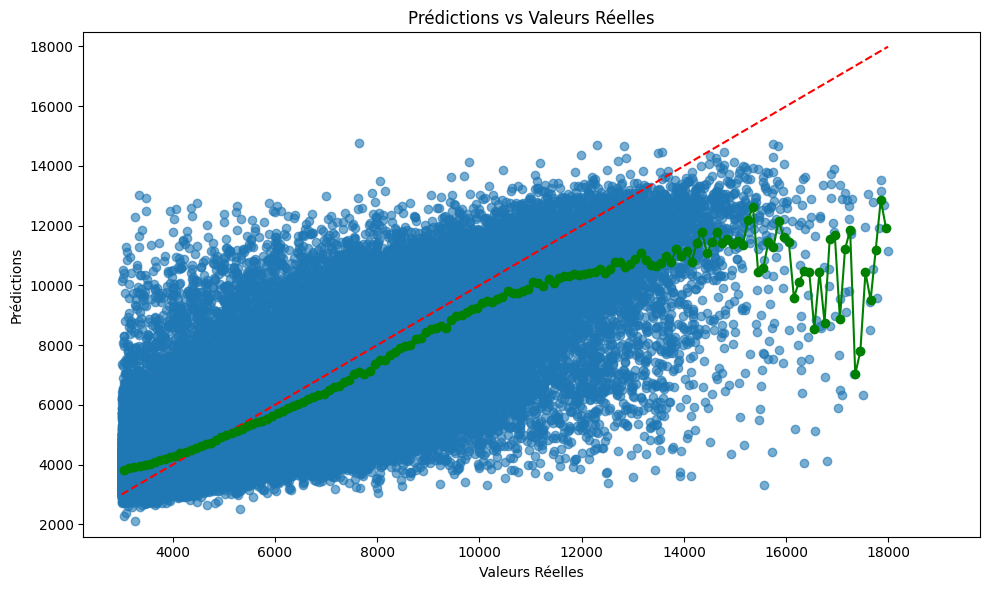

In [29]:
y_test = df_test_target.collect().to_numpy().ravel()
dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# Tri des données
bins = np.arange(min(y_test), max(y_test) + dx, dx)
bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
                    for i in range(len(bins)-1)]
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
        label="Moyenne par intervalle")
plt.title("Prédictions vs Valeurs Réelles")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")

plt.xlim(0.75*min(y_test),1.1*max(y_test))
plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
plt.tight_layout()

In [30]:
def predict_wrapper(X, len_physical=0):
    """
    Cette fonction reçoit X sous forme d'un array 2D combiné.
    Elle sépare les features en deux parties :
      - Les n_physical premières colonnes correspondent à X_physical.
      - Le reste correspond à X_contextual.
    Puis, elle appelle combined_model.predict() en passant un tuple.
    """
    n_physical = len_physical  # Nombre de colonnes pour X_physical
    X_physical = X[:, :n_physical]
    X_contextual = X[:, n_physical:]
    return combined_model.predict((X_physical, X_contextual))


def compute_shap_impact(model, X, sample_size = None):
    """
    Calcule l'impact des modèles sur le méta-modèle via SHAP.

    Parameters:
    - model: Instance de CombinedXGBModel (dont le stacking est activé)
    - X: Données d'entrée sous forme de LazyFrame Polars

    Returns:
    - impact_dict: Dictionnaire des impacts en pourcentage des modèles.
    """
    if not model.stacking:
        raise ValueError("Le calcul SHAP est uniquement applicable lorsque le stacking est activé.")

    # Transformation des données via les pipelines
    X_physical = physical_pipeline.fit_transform(X.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(X.select(contextual_features).collect())
    len_physical = X_physical.shape[1]

    # Combinaison des données sous forme d'un array 2D (par concaténation horizontale)
    X_combined = np.hstack((X_physical, X_contextual))
    if sample_size and sample_size < X_combined.shape[0]:
        indices = np.random.choice(X_combined.shape[0], size=sample_size, replace=False)
        X_sample = X_combined[indices]
    else:
        X_sample = X_combined
    # On définit une fonction callable pour SHAP qui prend en compte le découpage du tableau
    wrapped_predict = lambda X: predict_wrapper(X, len_physical)

    # On crée l'explainer en passant la fonction wrapped_predict et le background (ici X_combined)
    explainer = shap.Explainer(wrapped_predict, X_sample)
    shap_values = explainer(X_sample)

    # Calcul de l'impact moyen par feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Séparation des impacts pour les features physiques et contextuelles
    n_physical_features = len_physical
    physical_impact = mean_abs_shap[:n_physical_features].sum()
    contextual_impact = mean_abs_shap[n_physical_features:].sum()

    total_impact = physical_impact + contextual_impact
    impact_dict = {
        'physical_model_impact': (physical_impact / total_impact) * 100,
        'contextual_model_impact': (contextual_impact / total_impact) * 100
    }

    return impact_dict


compute_shap_impact(combined_model, df_test_features, sample_size=1500)

PermutationExplainer explainer: 1501it [15:19,  1.62it/s]                          


{'physical_model_impact': 51.283696589974696,
 'contextual_model_impact': 48.7163034100253}